# 03 - Análisis del Ecosistema Tecnológico

**Objetivo:** Analizar el panorama tecnológico global y chileno, identificando tendencias, brechas de adopción y oportunidades para desarrolladores.

Este notebook complementa el análisis de modelos predictivos (notebook 02) con un enfoque en:
- **Tecnologías más utilizadas** (lenguajes, frameworks, herramientas)
- **Tendencias temporales** (2023 vs 2025)
- **Comparación Chile vs Global**
- **Análisis de salarios por tecnología**
- **Recomendaciones estratégicas**

**Dataset:** Stack Overflow Developer Survey 2023 + 2025 (68,613 registros procesados)

In [2]:
import warnings

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del entorno
warnings.filterwarnings('ignore')

# Configuración de matplotlib
%matplotlib inline
%config InlineBackend.figure_formats = ['png', 'retina']

matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['figure.figsize'] = (14, 7)

# PALETA DE COLORES MODERNA (WCAG AA Compliant)
COLOR_PRIMARY = '#2E7D32'      # Verde oscuro - Modelos principales
COLOR_SECONDARY = '#1976D2'    # Azul oscuro - Modelos secundarios
COLOR_ACCENT = '#FF6F00'       # Naranja - Acentos/alertas
COLOR_SUCCESS = '#00796B'      # Teal oscuro - Éxito/F1-Score
COLOR_WARNING = '#C62828'      # Rojo oscuro - Advertencias/Accuracy

# Aplicar estilo moderno
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette([COLOR_PRIMARY, COLOR_SECONDARY, COLOR_ACCENT, COLOR_SUCCESS, COLOR_WARNING])

print("✅ Entorno configurado correctamente")
print(f"   Matplotlib backend: {matplotlib.get_backend()}")
print(f"   Paleta de colores: Moderna y accesible (WCAG AA)")

✅ Entorno configurado correctamente
   Matplotlib backend: inline
   Paleta de colores: Moderna y accesible (WCAG AA)


## 1. Carga de Datos y Configuración Inicial

Cargaremos los datasets raw (datos originales sin procesar) para analizar variables categóricas como lenguajes, frameworks y países.

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd

# Configurar el proyecto root y sesión Kedro
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()

print("=" * 80)
print("CARGA DE DATASETS MEDIANTE KEDRO")
print("=" * 80)

# Cargar el catálogo de Kedro
try:
    from kedro.framework.session import KedroSession
    from kedro.framework.startup import bootstrap_project
    
    # Bootstrap del proyecto
    bootstrap_project(project_root)
    
    # Crear sesión de Kedro
    session = KedroSession.create(project_path=project_root)
    context = session.load_context()
    catalog = context.catalog
    
    print("✅ Catálogo de Kedro cargado correctamente\n")
    
    # Cargar StackOverflow 2023 desde el catálogo
    try:
        df_2023 = catalog.load("datos_crudos_so_2023")
        print(f"✅ Stack Overflow 2023 cargado: {len(df_2023):,} registros")
        print(f"   Columnas disponibles: {len(df_2023.columns)}")
    except Exception as e:
        print(f"❌ Error cargando SO2023: {e}")
        df_2023 = pd.DataFrame()
    
    # StackOverflow 2025 (placeholder, no existe todavía)
    print(f"\n⚠️  Stack Overflow 2025 no disponible aún")
    df_2025 = pd.DataFrame()
    
except Exception as e:
    print(f"❌ Error inicializando Kedro: {e}")
    print("   Intentando carga directa desde CSV...\n")
    
    # Fallback: Carga directa desde CSV
    so2023_path = project_root / 'data' / '01_raw' / 'stackoverflow_2023' / 'stack_overflow_survey_results_public.csv'
    
    if so2023_path.exists():
        df_2023 = pd.read_csv(so2023_path, encoding='utf-8-sig')
        print(f"✅ Stack Overflow 2023 cargado (directo): {len(df_2023):,} registros")
        print(f"   Columnas disponibles: {len(df_2023.columns)}")
    else:
        print(f"❌ No se encontró: {so2023_path}")
        df_2023 = pd.DataFrame()
    
    df_2025 = pd.DataFrame()

print("\n" + "=" * 80)

CARGA DE DATASETS MEDIANTE KEDRO


[11/03/25 15:54:30] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=121785;file://c:\Users\hdagu\Documents\ML_Analisis_Ecosistema_Dev\ML_Analisis_Ecosistema_Dev\.venv\Lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=198612;file://c:\Users\hdagu\Documents\ML_Analisis_Ecosistema_Dev\ML_Analisis_Ecosistema_Dev\.venv\Lib\site-packages\kedro_telemetry\plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

✅ Catálogo de Kedro cargado correctamente



                    INFO     Loading data from datos_crudos_so_2023 (CSVDataset)...             ]8;id=545837;file://c:\Users\hdagu\Documents\ML_Analisis_Ecosistema_Dev\ML_Analisis_Ecosistema_Dev\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=186806;file://c:\Users\hdagu\Documents\ML_Analisis_Ecosistema_Dev\ML_Analisis_Ecosistema_Dev\.venv\Lib\site-packages\kedro\io\data_catalog.py#401\401]8;;\

✅ Stack Overflow 2023 cargado: 89,184 registros
   Columnas disponibles: 84

⚠️  Stack Overflow 2025 no disponible aún



## 2. Exploración Inicial: Columnas Disponibles

Identifiquemos las columnas relacionadas con tecnologías, experiencia y demografía.

In [4]:
if not df_2023.empty:
    print("=" * 80)
    print("COLUMNAS CLAVE DEL DATASET SO2023")
    print("=" * 80)

    # Columnas de interés
    tech_cols = [col for col in df_2023.columns if 'Language' in col or 'Database' in col or
                 'Platform' in col or 'Framework' in col or 'Tool' in col or 'Cloud' in col]

    demo_cols = [col for col in df_2023.columns if 'Country' in col or 'Age' in col or
                 'Gender' in col or 'EdLevel' in col]

    exp_cols = [col for col in df_2023.columns if 'Years' in col or 'DevType' in col]

    comp_cols = [col for col in df_2023.columns if 'Comp' in col or 'Salary' in col]

    print(f"\n📊 Tecnologías ({len(tech_cols)} columnas):")
    for col in tech_cols[:10]:  # Mostrar primeras 10
        print(f"   - {col}")
    if len(tech_cols) > 10:
        print(f"   ... y {len(tech_cols) - 10} más")

    print(f"\n👥 Demografía ({len(demo_cols)} columnas):")
    for col in demo_cols:
        print(f"   - {col}")

    print(f"\n💼 Experiencia ({len(exp_cols)} columnas):")
    for col in exp_cols:
        print(f"   - {col}")

    print(f"\n💰 Compensación ({len(comp_cols)} columnas):")
    for col in comp_cols:
        print(f"   - {col}")

    print("\n" + "=" * 80)
else:
    print("⚠️  No se pudo explorar el dataset")

COLUMNAS CLAVE DEL DATASET SO2023

📊 Tecnologías (14 columnas):
   - BuyNewTool
   - LanguageHaveWorkedWith
   - LanguageWantToWorkWith
   - DatabaseHaveWorkedWith
   - DatabaseWantToWorkWith
   - PlatformHaveWorkedWith
   - PlatformWantToWorkWith
   - ToolsTechHaveWorkedWith
   - ToolsTechWantToWorkWith
   - NEWCollabToolsHaveWorkedWith
   ... y 4 más

👥 Demografía (3 columnas):
   - Age
   - EdLevel
   - Country

💼 Experiencia (3 columnas):
   - YearsCode
   - YearsCodePro
   - DevType

💰 Compensación (2 columnas):
   - CompTotal
   - ConvertedCompYearly



## 3. Análisis de Lenguajes de Programación

### 3.1 Top 20 Lenguajes Más Utilizados (Global)

ANÁLISIS DE LENGUAJES DE PROGRAMACIÓN

Total de respuestas válidas: 87,140
Lenguajes únicos identificados: 51

Top 20 Lenguajes Más Utilizados:
--------------------------------------------------------------------------------
 1. JavaScript                55,711 devs (62.47%)
 2. HTML/CSS                  46,396 devs (52.02%)
 3. Python                    43,158 devs (48.39%)
 4. SQL                       42,623 devs (47.79%)
 5. TypeScript                34,041 devs (38.17%)
 6. Bash/Shell (all shells)   28,351 devs (31.79%)
 7. Java                      26,757 devs (30.00%)
 8. C#                        24,193 devs (27.13%)
 9. C++                       19,634 devs (22.02%)
10. C                         16,940 devs (18.99%)
11. PHP                       16,274 devs (18.25%)
12. PowerShell                11,902 devs (13.35%)
13. Go                        11,592 devs (13.00%)
14. Rust                      11,427 devs (12.81%)
15. Kotlin                     7,935 devs ( 8.90%)
16. Ruby  

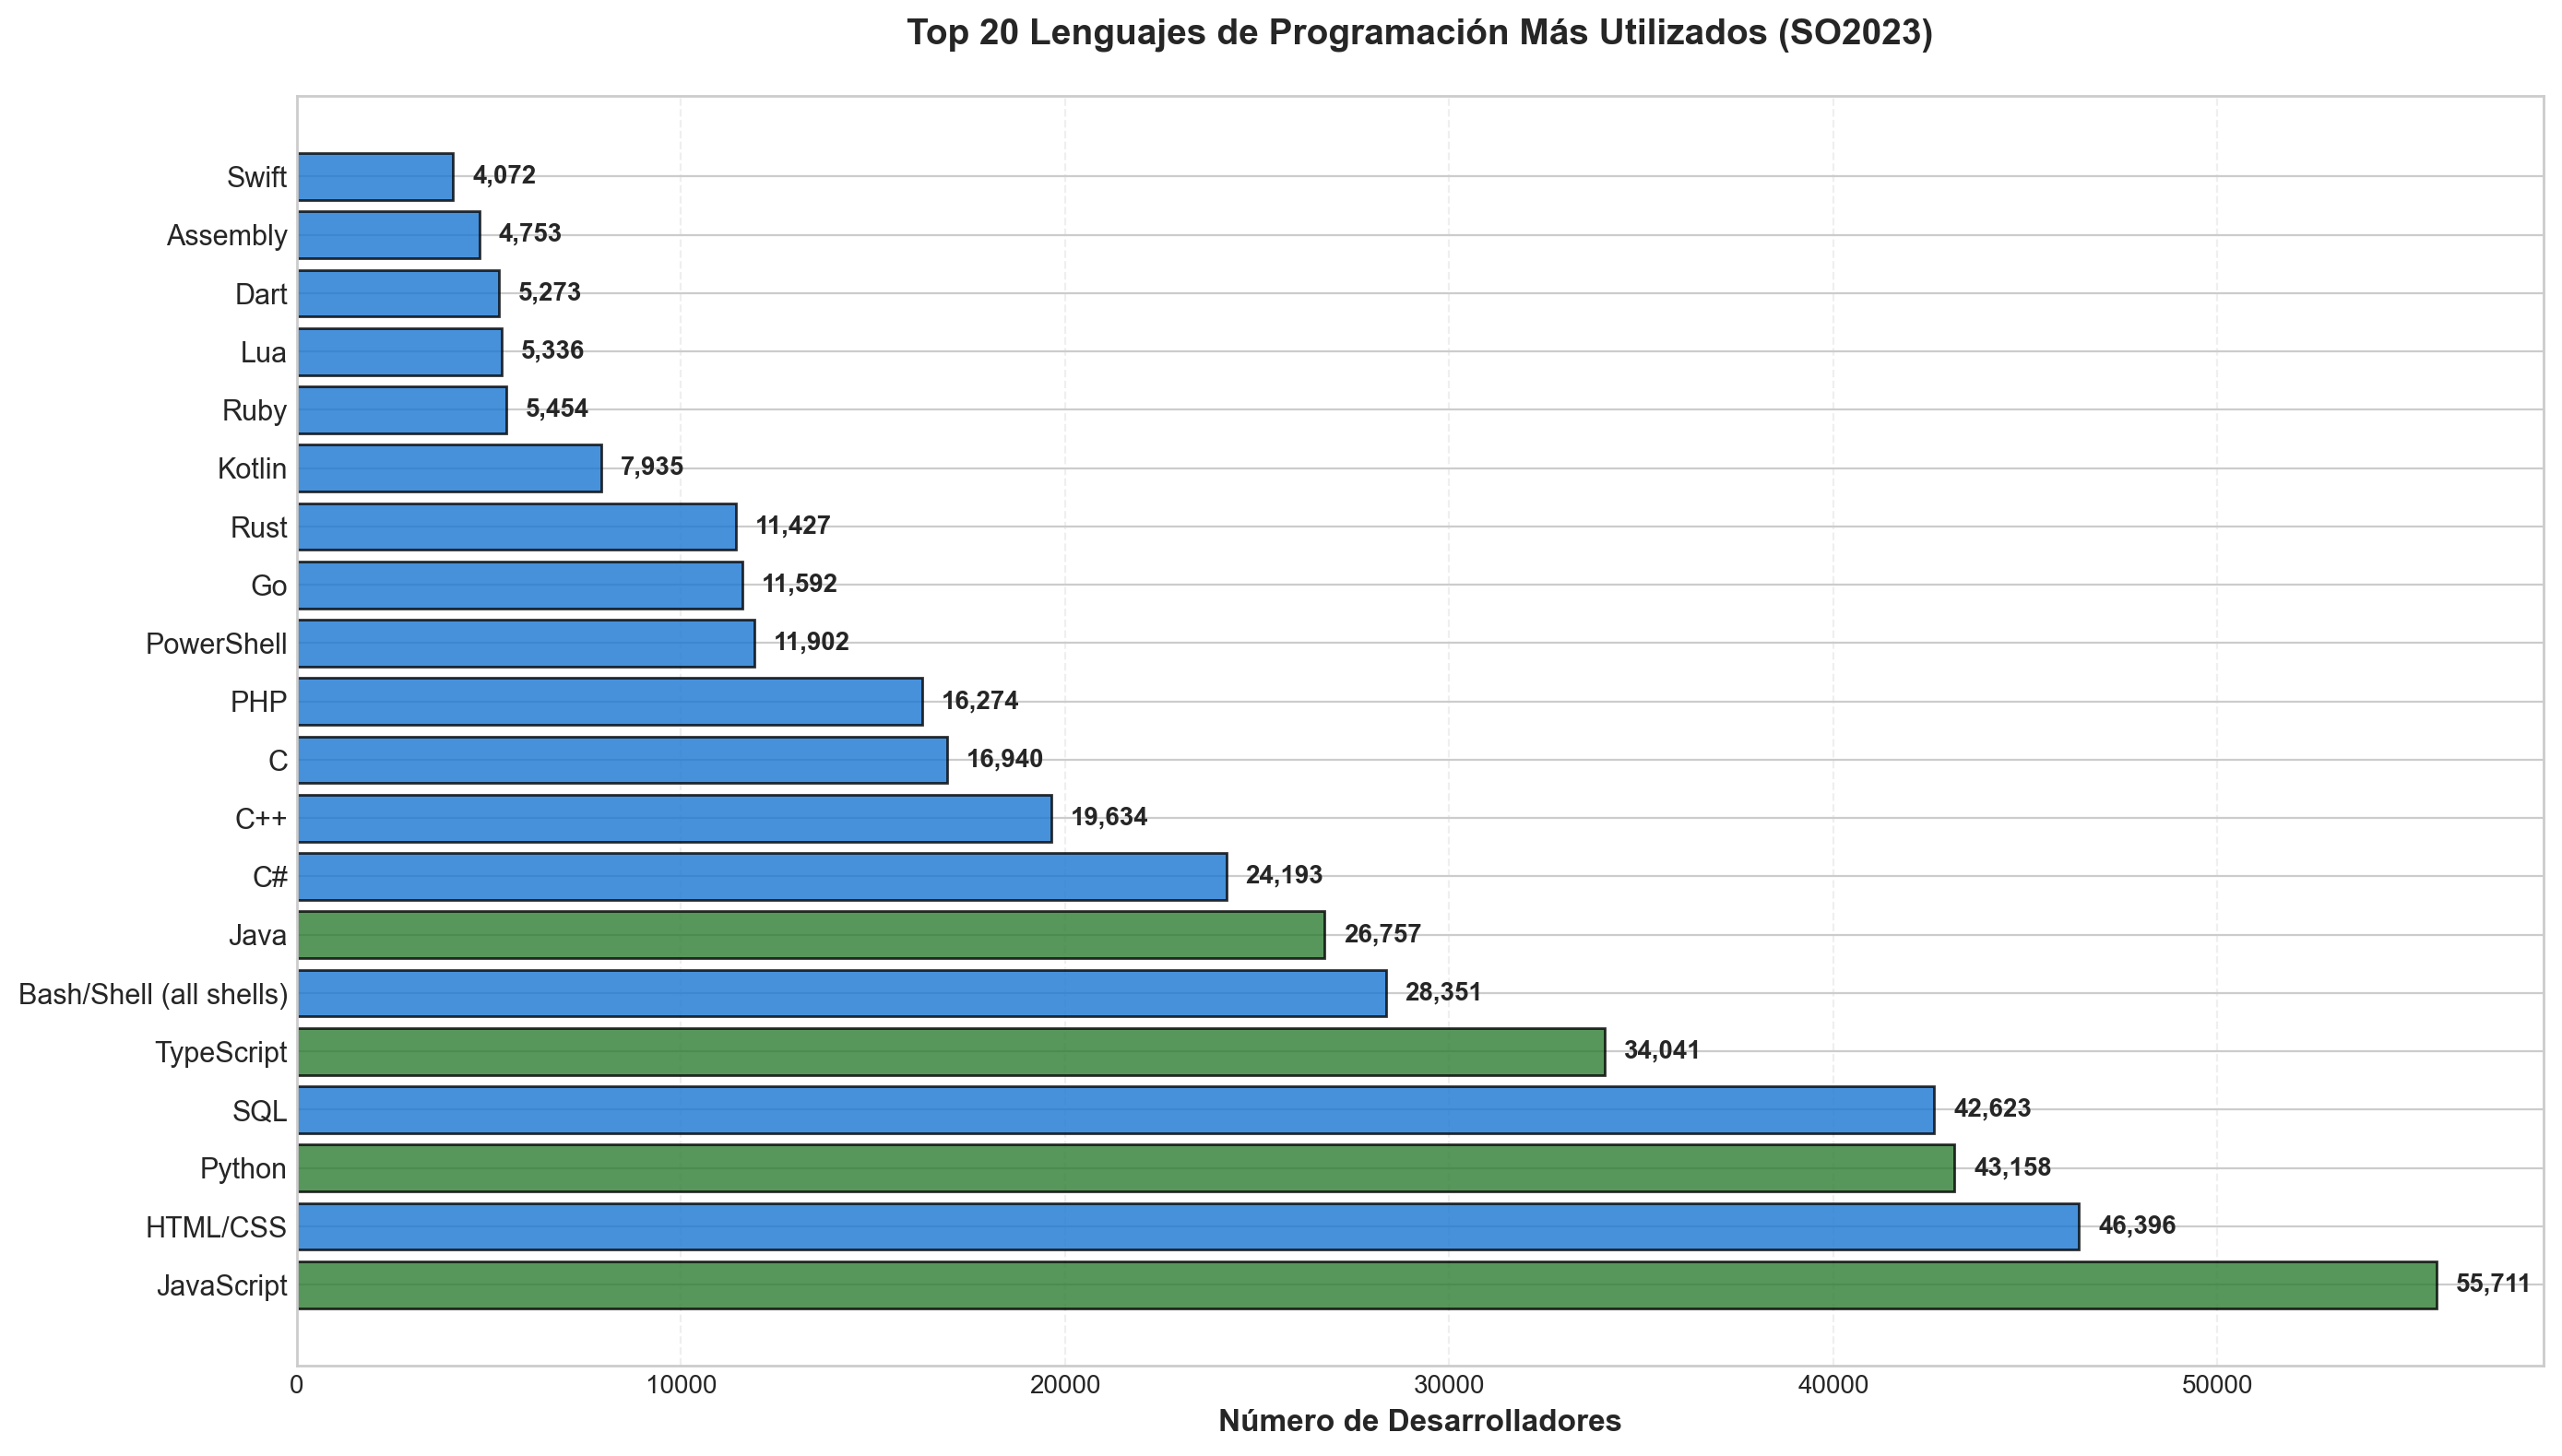


✅ Gráfico guardado: top_languages_global.png


In [5]:
if not df_2023.empty and 'LanguageHaveWorkedWith' in df_2023.columns:
    print("=" * 80)
    print("ANÁLISIS DE LENGUAJES DE PROGRAMACIÓN")
    print("=" * 80)

    # Procesar lenguajes (vienen separados por ';')
    languages_series = df_2023['LanguageHaveWorkedWith'].dropna().str.split(';').explode()
    language_counts = languages_series.value_counts()

    print(f"\nTotal de respuestas válidas: {len(df_2023['LanguageHaveWorkedWith'].dropna()):,}")
    print(f"Lenguajes únicos identificados: {len(language_counts)}")

    # Top 20
    top_20_languages = language_counts.head(20)

    print("\nTop 20 Lenguajes Más Utilizados:")
    print("-" * 80)
    for i, (lang, count) in enumerate(top_20_languages.items(), 1):
        percentage = (count / len(df_2023)) * 100
        print(f"{i:2d}. {lang:25s} {count:6,} devs ({percentage:5.2f}%)")

    # Visualización
    fig, ax = plt.subplots(figsize=(14, 8))

    colors = [COLOR_PRIMARY if lang in ['Python', 'JavaScript', 'TypeScript', 'Java']
              else COLOR_SECONDARY for lang in top_20_languages.index]

    bars = ax.barh(range(len(top_20_languages)), top_20_languages.values,
                   color=colors, alpha=0.8, edgecolor='black')

    ax.set_yticks(range(len(top_20_languages)))
    ax.set_yticklabels(top_20_languages.index, fontsize=11)
    ax.set_xlabel('Número de Desarrolladores', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 Lenguajes de Programación Más Utilizados (SO2023)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Añadir valores en barras
    for i, (_bar, count) in enumerate(zip(bars, top_20_languages.values, strict=True)):
        ax.text(count + 500, i, f'{count:,}',
                va='center', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / 'data' / '08_reporting' / 'top_languages_global.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Gráfico guardado: top_languages_global.png")
    print("=" * 80)
else:
    print("⚠️  Columna 'LanguageHaveWorkedWith' no disponible")

### 3.2 Lenguajes en Chile vs Global

COMPARACIÓN: LENGUAJES CHILE VS GLOBAL

Desarrolladores chilenos en SO2023: 248

Comparación Top 15 Lenguajes:
--------------------------------------------------------------------------------
               Lenguaje  Chile (%)  Global (%)  Diferencia
             JavaScript  74.193548   62.467483   11.726065
               HTML/CSS  56.048387   52.022784    4.025603
                 Python  55.241935   48.392088    6.849847
                    SQL  56.048387   47.792205    8.256182
             TypeScript  44.354839   38.169403    6.185436
Bash/Shell (all shells)  29.032258   31.789334   -2.757076
                   Java  28.225806   30.002018   -1.776212
                     C#  20.564516   27.127063   -6.562547
                    C++  13.306452   22.015160   -8.708708
                      C  14.919355   18.994438   -4.075084
                    PHP  25.000000   18.247668    6.752332
             PowerShell   9.677419   13.345443   -3.668024
                     Go  14.112903   12.9

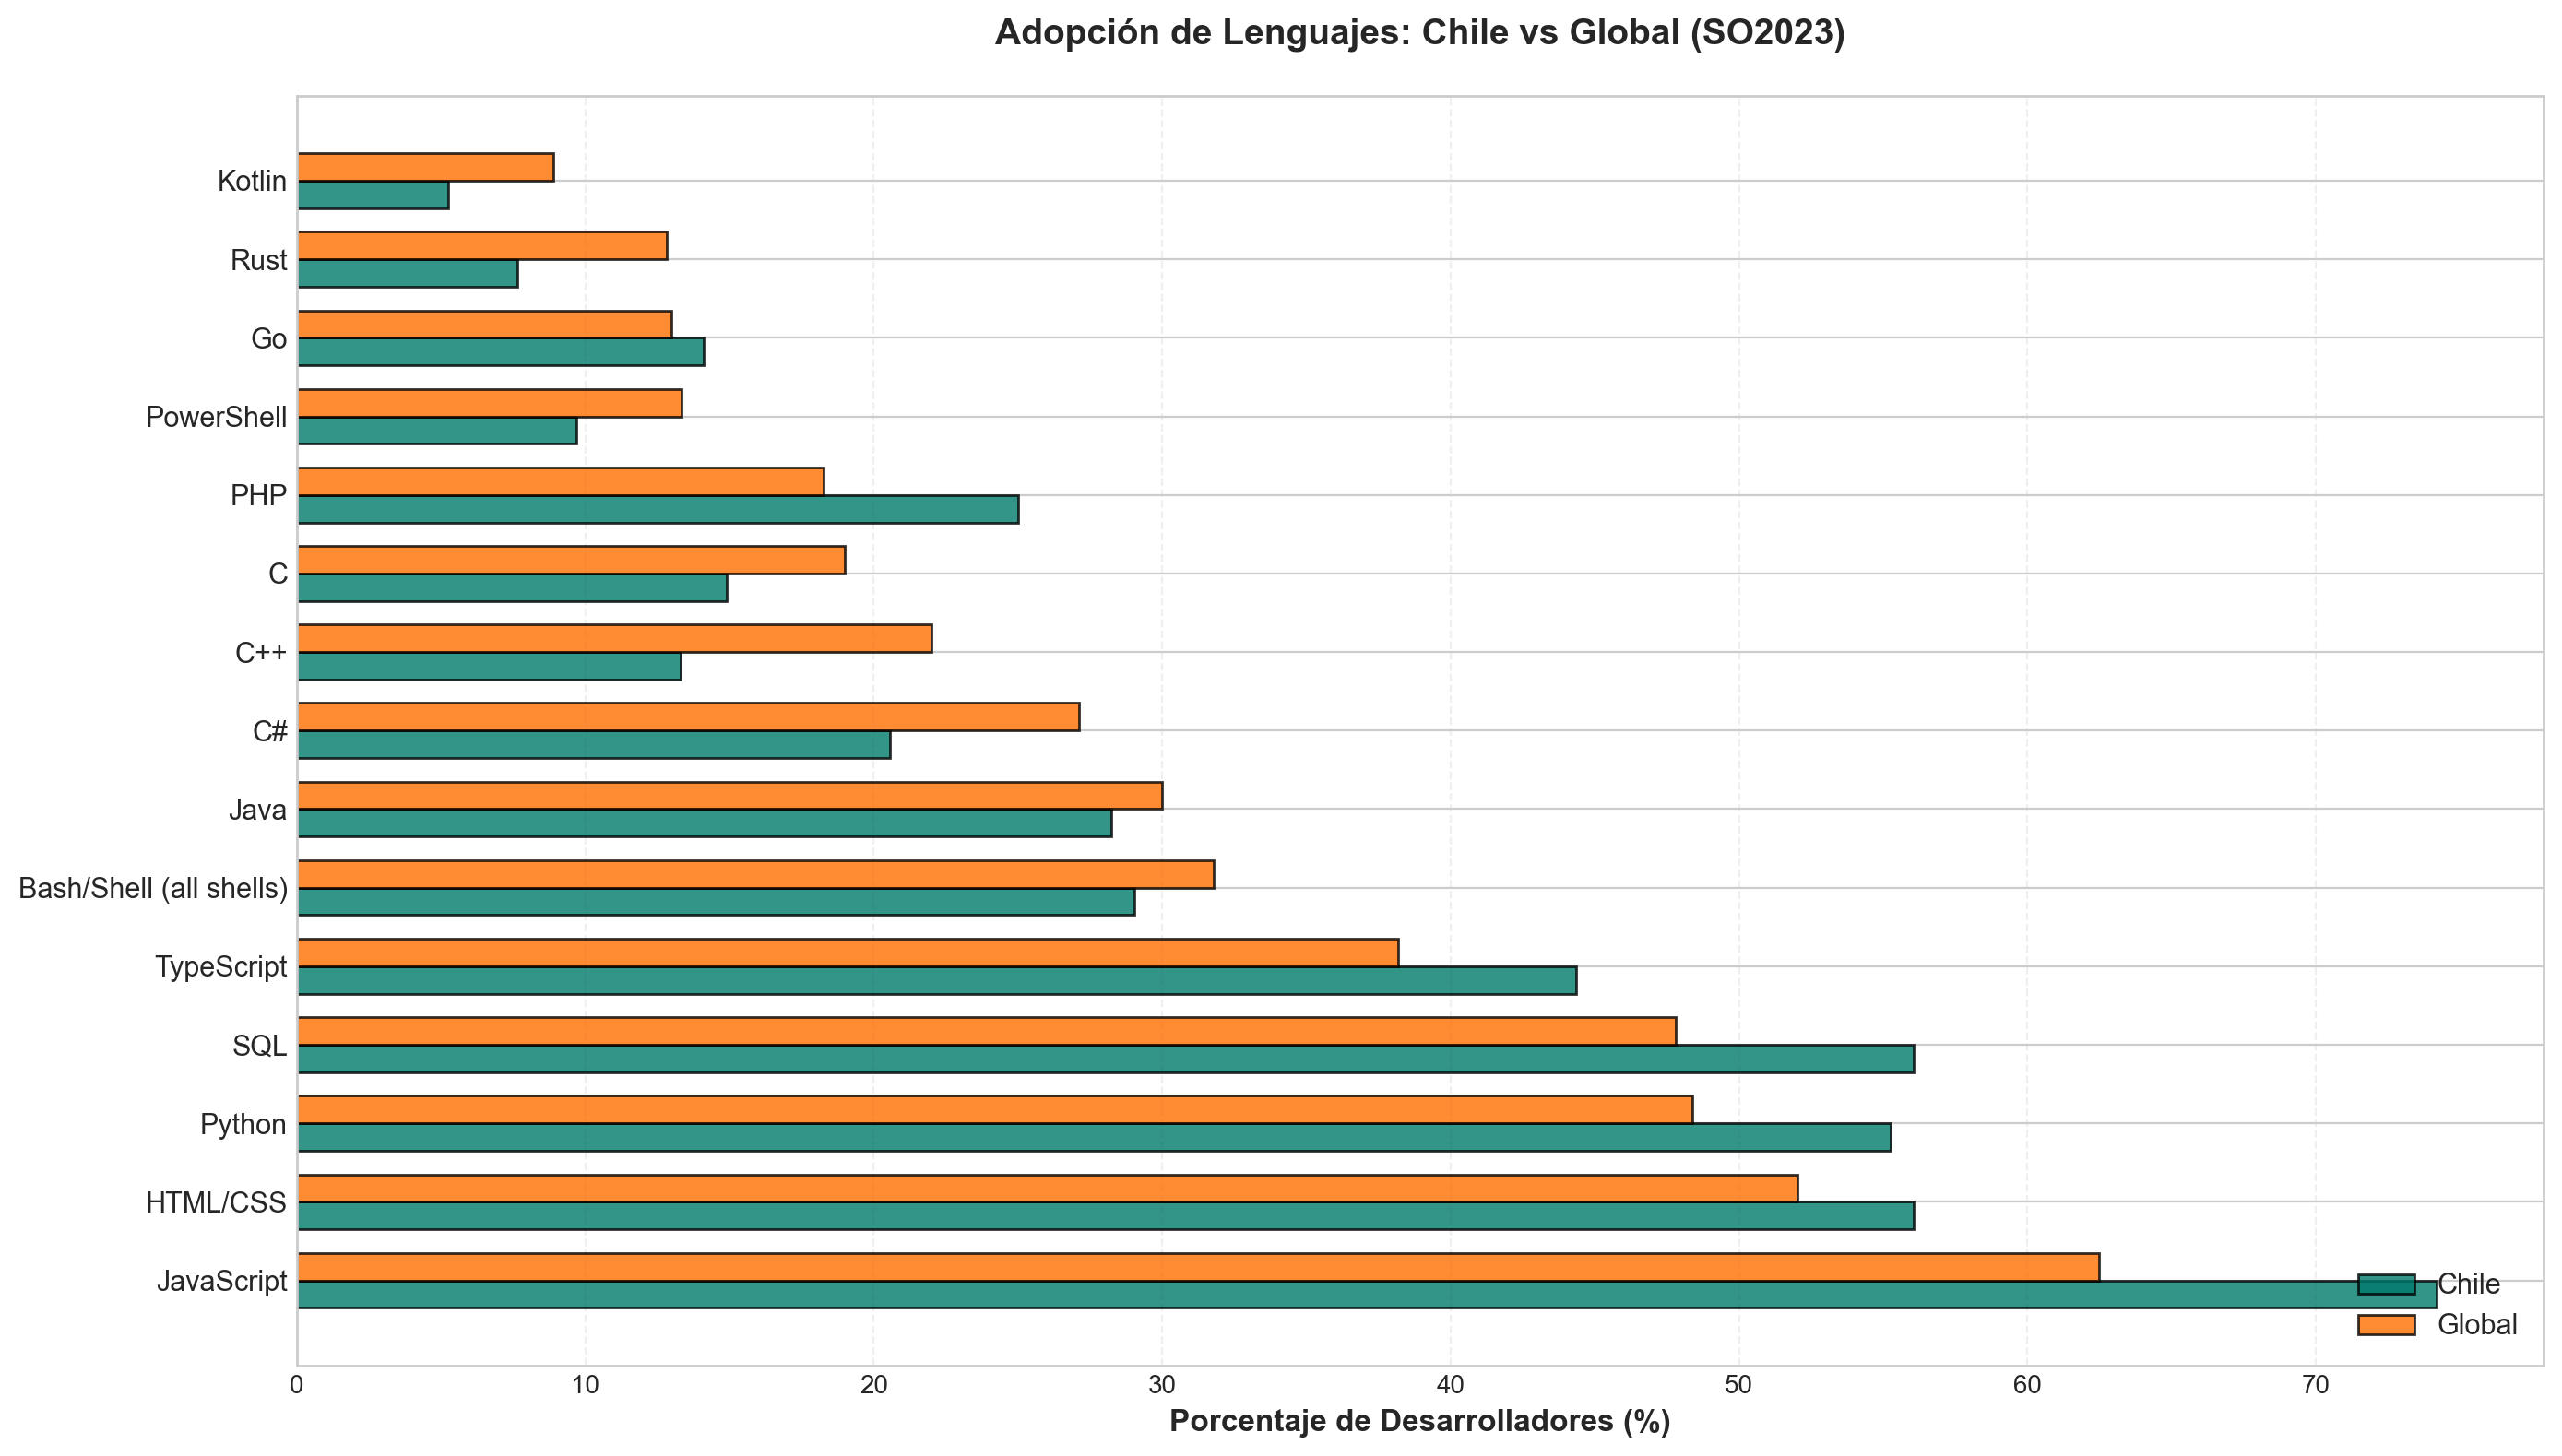


✅ Gráfico guardado: languages_chile_vs_global.png

BRECHAS IDENTIFICADAS (Chile vs Global)

Lenguajes más sobre-representados en Chile:
   JavaScript           +11.73% vs global
   SQL                  + 8.26% vs global
   Python               + 6.85% vs global
   PHP                  + 6.75% vs global
   TypeScript           + 6.19% vs global

Lenguajes menos adoptados en Chile:
   C++                  -8.71% vs global
   C#                   -6.56% vs global
   Rust                 -5.15% vs global
   C                    -4.08% vs global
   PowerShell           -3.67% vs global


In [6]:
if not df_2023.empty and 'Country' in df_2023.columns and 'LanguageHaveWorkedWith' in df_2023.columns:
    print("=" * 80)
    print("COMPARACIÓN: LENGUAJES CHILE VS GLOBAL")
    print("=" * 80)

    # Filtrar desarrolladores chilenos
    df_chile = df_2023[df_2023['Country'] == 'Chile'].copy()

    if len(df_chile) > 0:
        print(f"\nDesarrolladores chilenos en SO2023: {len(df_chile)}")

        # Lenguajes en Chile
        chile_languages = df_chile['LanguageHaveWorkedWith'].dropna().str.split(';').explode()
        chile_lang_counts = chile_languages.value_counts()

        # Calcular porcentajes
        chile_percentages = (chile_lang_counts / len(df_chile)) * 100
        global_percentages = (language_counts / len(df_2023)) * 100

        # Top 15 lenguajes (por popularidad global)
        top_15_langs = language_counts.head(15).index

        comparison_data = pd.DataFrame({
            'Lenguaje': top_15_langs,
            'Chile (%)': [chile_percentages.get(lang, 0) for lang in top_15_langs],
            'Global (%)': [global_percentages.get(lang, 0) for lang in top_15_langs]
        })

        comparison_data['Diferencia'] = comparison_data['Chile (%)'] - comparison_data['Global (%)']
        comparison_data = comparison_data.sort_values('Global (%)', ascending=False)

        print("\nComparación Top 15 Lenguajes:")
        print("-" * 80)
        print(comparison_data.to_string(index=False))

        # Visualización
        fig, ax = plt.subplots(figsize=(14, 8))

        x = np.arange(len(comparison_data))
        width = 0.35

        bars1 = ax.barh(x - width/2, comparison_data['Chile (%)'], width,
                        label='Chile', color=COLOR_SUCCESS, alpha=0.8, edgecolor='black')
        bars2 = ax.barh(x + width/2, comparison_data['Global (%)'], width,
                        label='Global', color=COLOR_ACCENT, alpha=0.8, edgecolor='black')

        ax.set_yticks(x)
        ax.set_yticklabels(comparison_data['Lenguaje'], fontsize=11)
        ax.set_xlabel('Porcentaje de Desarrolladores (%)', fontsize=12, fontweight='bold')
        ax.set_title('Adopción de Lenguajes: Chile vs Global (SO2023)',
                     fontsize=14, fontweight='bold', pad=20)
        ax.legend(fontsize=11, loc='lower right')
        ax.grid(axis='x', alpha=0.3, linestyle='--')

        plt.tight_layout()
        plt.savefig(project_root / 'data' / '08_reporting' / 'languages_chile_vs_global.png',
                    dpi=300, bbox_inches='tight')
        plt.show()

        print("\n✅ Gráfico guardado: languages_chile_vs_global.png")

        # Identificar brechas significativas
        print("\n" + "=" * 80)
        print("BRECHAS IDENTIFICADAS (Chile vs Global)")
        print("=" * 80)

        top_gaps = comparison_data.nlargest(5, 'Diferencia')
        print("\nLenguajes más sobre-representados en Chile:")
        for _, row in top_gaps.iterrows():
            print(f"   {row['Lenguaje']:20s} +{row['Diferencia']:5.2f}% vs global")

        bottom_gaps = comparison_data.nsmallest(5, 'Diferencia')
        print("\nLenguajes menos adoptados en Chile:")
        for _, row in bottom_gaps.iterrows():
            print(f"   {row['Lenguaje']:20s} {row['Diferencia']:5.2f}% vs global")

        print("=" * 80)
    else:
        print("⚠️  No se encontraron desarrolladores chilenos en el dataset")
else:
    print("⚠️  Columnas necesarias no disponibles")

## 4. Análisis de Frameworks y Herramientas

### 4.1 Top Frameworks Web

ANÁLISIS DE FRAMEWORKS WEB

Total de respuestas válidas: 66,938
Frameworks únicos: 34

Top 15 Frameworks Web:
--------------------------------------------------------------------------------
 1. Node.js                        30,626 devs (34.34%)
 2. React                          29,137 devs (32.67%)
 3. jQuery                         15,784 devs (17.70%)
 4. Express                        13,843 devs (15.52%)
 5. Angular                        12,537 devs (14.06%)
 6. Next.js                        11,972 devs (13.42%)
 7. ASP.NET CORE                   11,896 devs (13.34%)
 8. Vue.js                         11,758 devs (13.18%)
 9. WordPress                       9,604 devs (10.77%)
10. ASP.NET                         9,185 devs (10.30%)
11. Flask                           8,734 devs ( 9.79%)
12. Spring Boot                     8,583 devs ( 9.62%)
13. Django                          8,238 devs ( 9.24%)
14. Laravel                         5,440 devs ( 6.10%)
15. FastAPI              

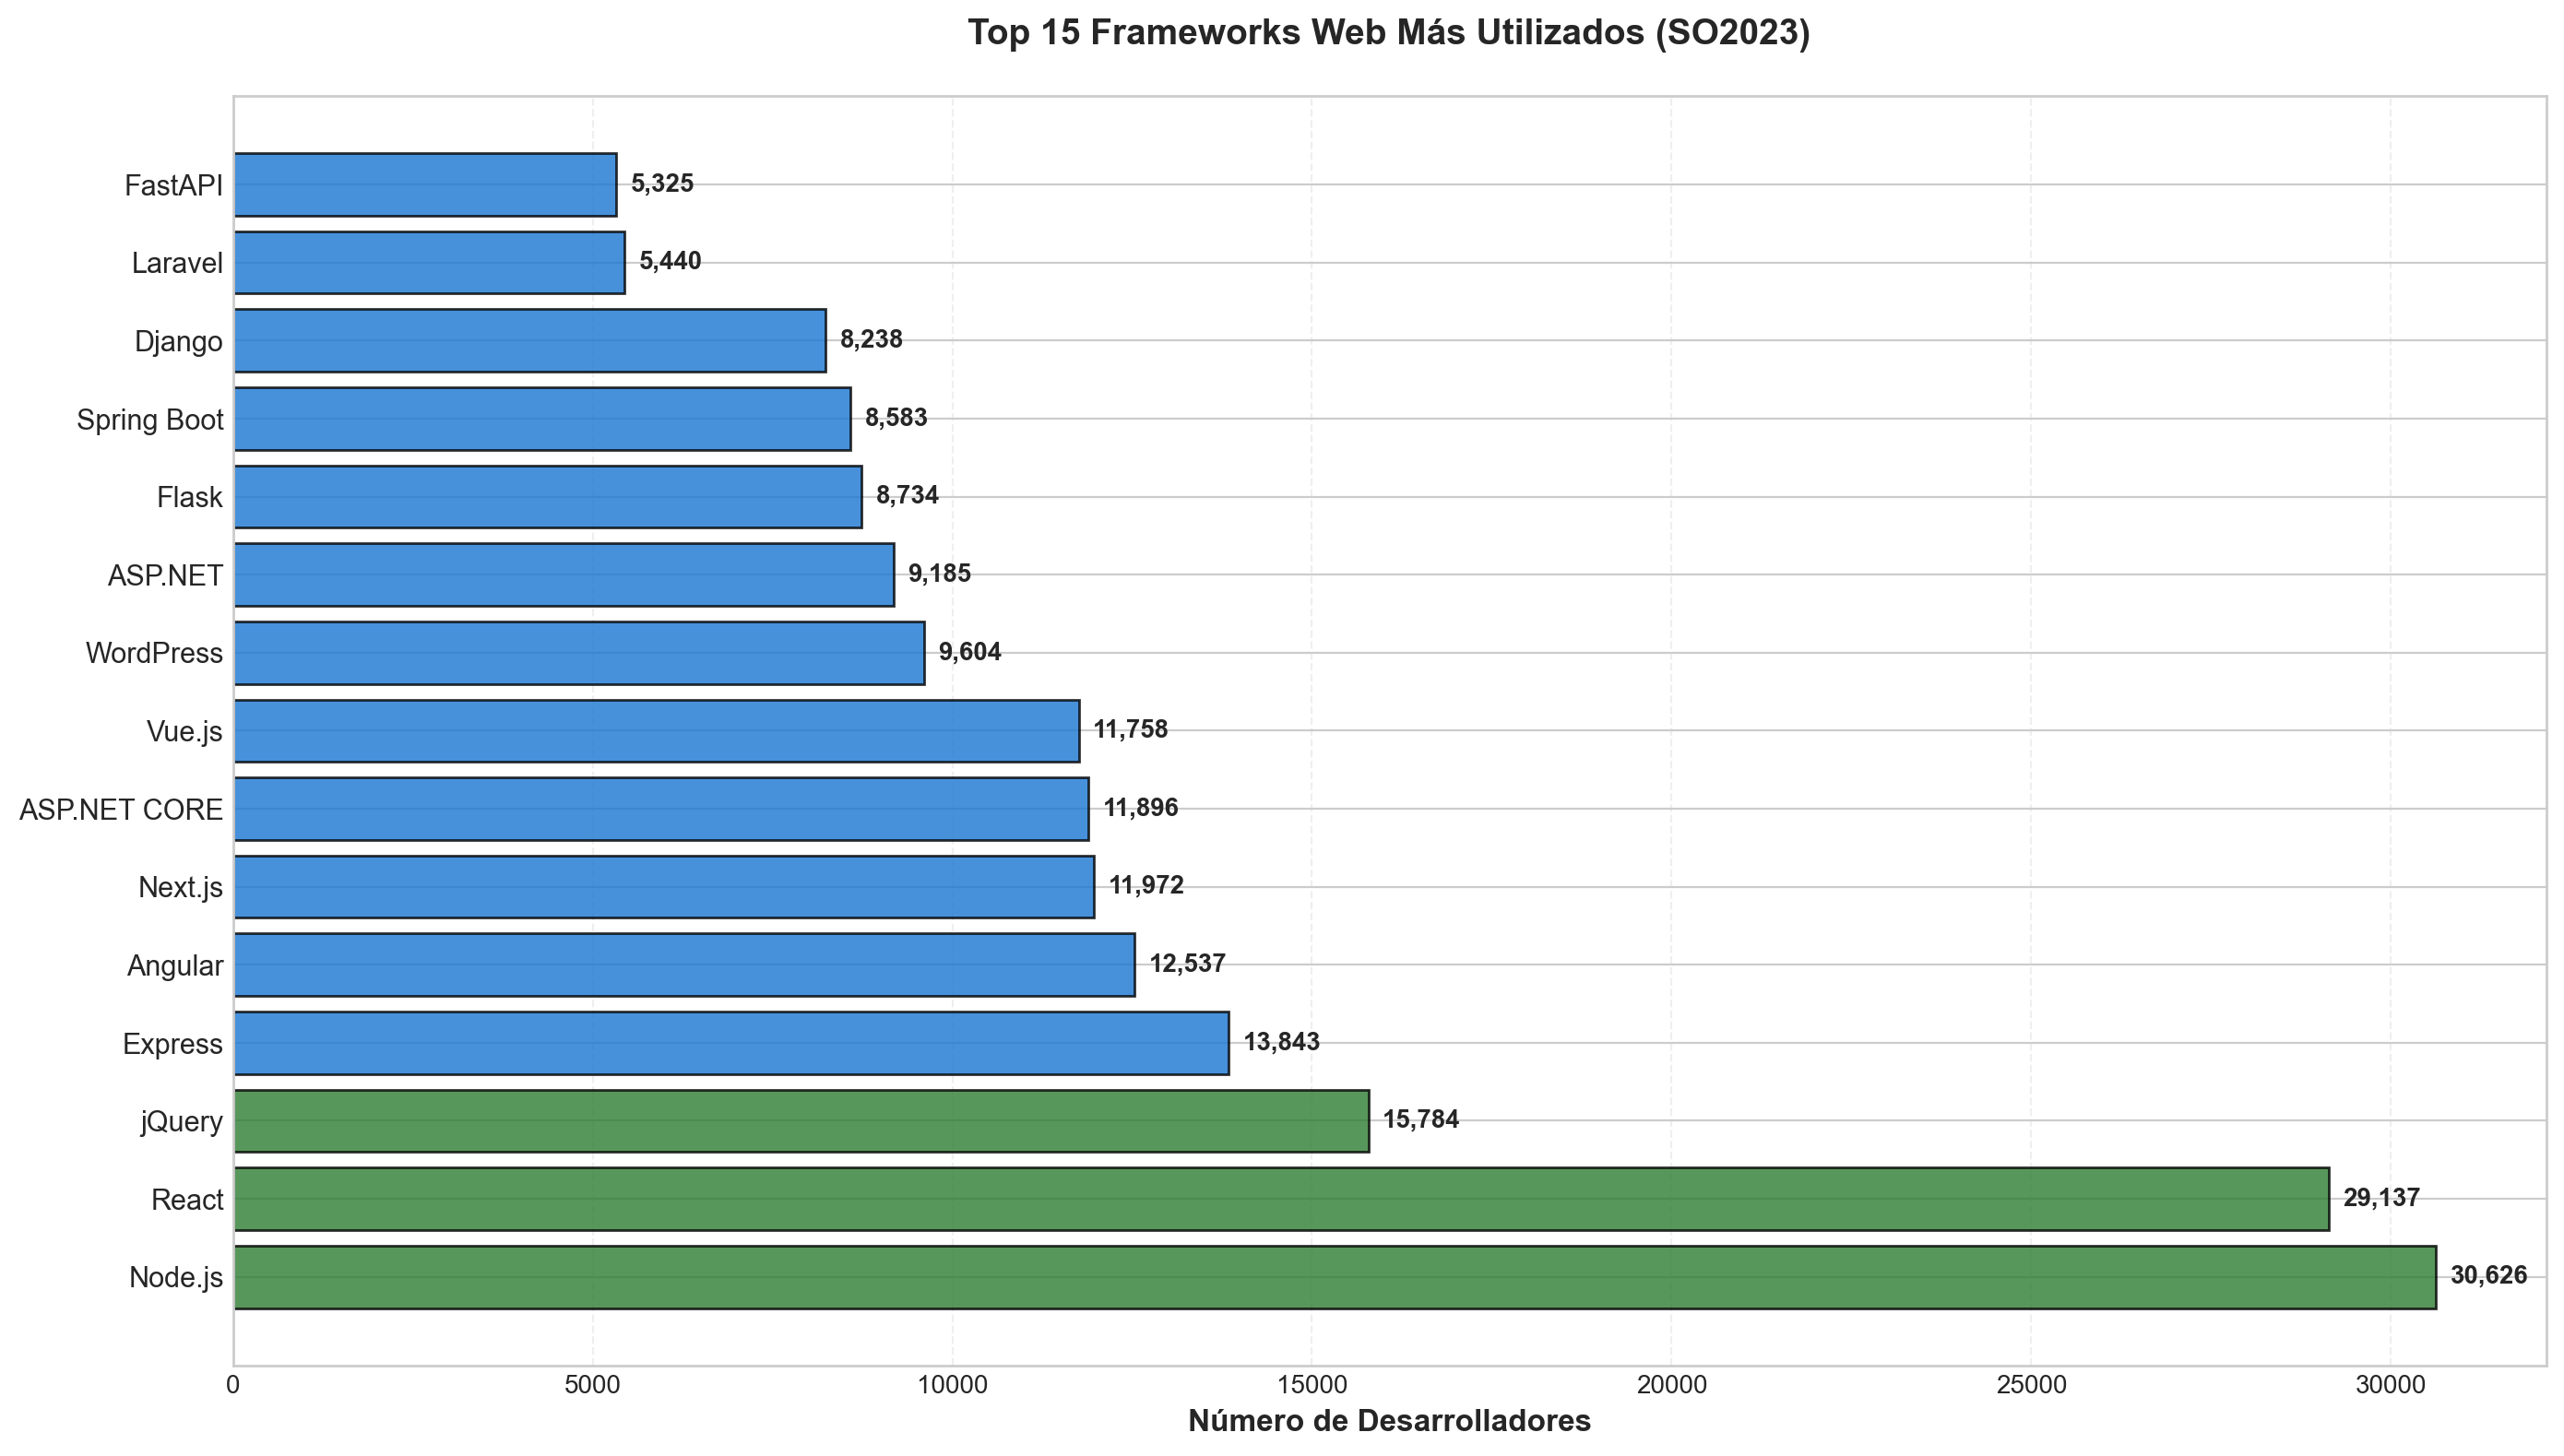


✅ Gráfico guardado: top_frameworks_global.png


In [7]:
if not df_2023.empty and 'WebframeHaveWorkedWith' in df_2023.columns:
    print("=" * 80)
    print("ANÁLISIS DE FRAMEWORKS WEB")
    print("=" * 80)

    # Procesar frameworks
    frameworks_series = df_2023['WebframeHaveWorkedWith'].dropna().str.split(';').explode()
    framework_counts = frameworks_series.value_counts()

    print(f"\nTotal de respuestas válidas: {len(df_2023['WebframeHaveWorkedWith'].dropna()):,}")
    print(f"Frameworks únicos: {len(framework_counts)}")

    # Top 15
    top_15_frameworks = framework_counts.head(15)

    print("\nTop 15 Frameworks Web:")
    print("-" * 80)
    for i, (fw, count) in enumerate(top_15_frameworks.items(), 1):
        percentage = (count / len(df_2023)) * 100
        print(f"{i:2d}. {fw:30s} {count:6,} devs ({percentage:5.2f}%)")

    # Visualización
    fig, ax = plt.subplots(figsize=(14, 8))

    # Colores: verde para los 3 más populares, azul para el resto
    colors = [COLOR_PRIMARY, COLOR_PRIMARY, COLOR_PRIMARY] + [COLOR_SECONDARY] * 12

    bars = ax.barh(range(len(top_15_frameworks)), top_15_frameworks.values,
                   color=colors, alpha=0.8, edgecolor='black')

    ax.set_yticks(range(len(top_15_frameworks)))
    ax.set_yticklabels(top_15_frameworks.index, fontsize=11)
    ax.set_xlabel('Número de Desarrolladores', fontsize=12, fontweight='bold')
    ax.set_title('Top 15 Frameworks Web Más Utilizados (SO2023)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Añadir valores
    for i, (_bar, count) in enumerate(zip(bars, top_15_frameworks.values, strict=True)):
        ax.text(count + 200, i, f'{count:,}',
                va='center', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / 'data' / '08_reporting' / 'top_frameworks_global.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Gráfico guardado: top_frameworks_global.png")
    print("=" * 80)
else:
    print("⚠️  Columna 'WebframeHaveWorkedWith' no disponible")

### 4.2 Herramientas de DevOps y Cloud

ANÁLISIS DE HERRAMIENTAS DEVOPS Y CLOUD

Total de respuestas válidas: 77,884
Herramientas únicas: 55

Top 20 Herramientas DevOps/Cloud:
--------------------------------------------------------------------------------
 1. Docker                              41,369 devs (46.39%)
 2. npm                                 39,609 devs (44.41%)
 3. Pip                                 23,281 devs (26.10%)
 4. Homebrew                            17,647 devs (19.79%)
 5. Yarn                                17,545 devs (19.67%)
 6. Webpack                             16,665 devs (18.69%)
 7. Make                                16,161 devs (18.12%)
 8. Kubernetes                          15,260 devs (17.11%)
 9. NuGet                               12,235 devs (13.72%)
10. Maven (build tool)                  12,109 devs (13.58%)
11. Gradle                              11,961 devs (13.41%)
12. Vite                                11,807 devs (13.24%)
13. Visual Studio Solution              11,751 devs

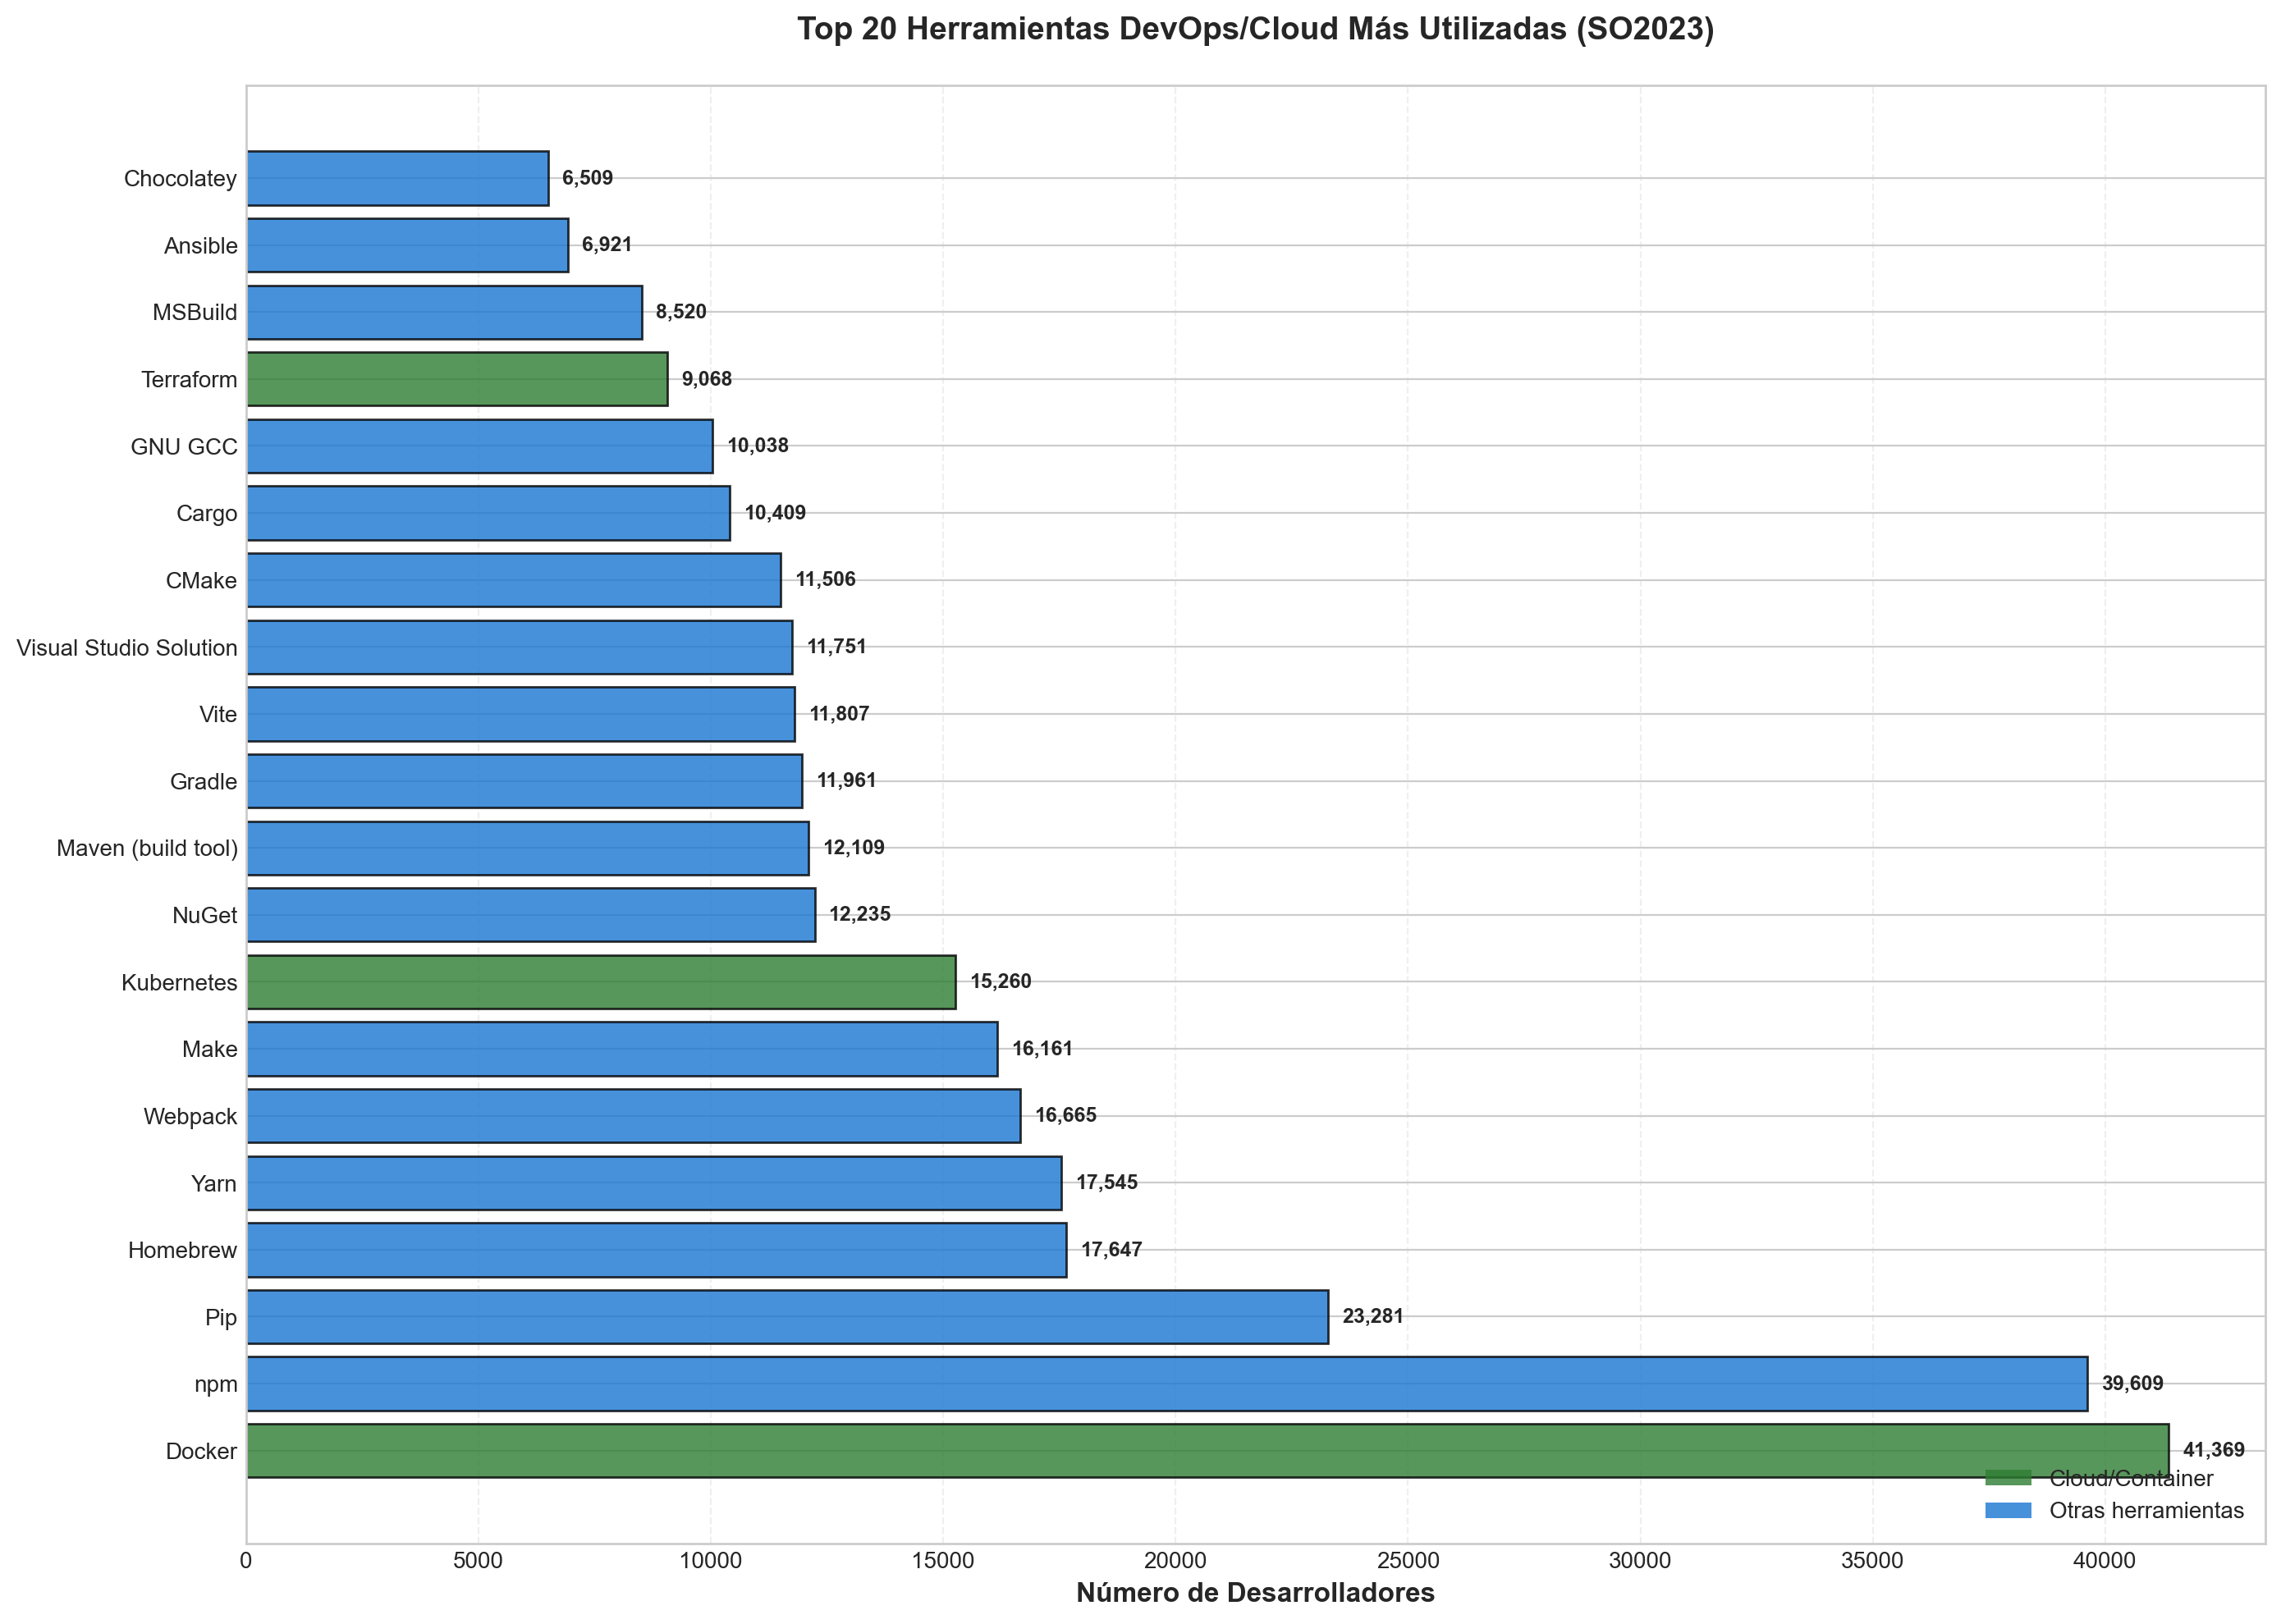


✅ Gráfico guardado: top_devops_tools_global.png


In [8]:
if not df_2023.empty and 'ToolsTechHaveWorkedWith' in df_2023.columns:
    print("=" * 80)
    print("ANÁLISIS DE HERRAMIENTAS DEVOPS Y CLOUD")
    print("=" * 80)

    # Procesar herramientas
    tools_series = df_2023['ToolsTechHaveWorkedWith'].dropna().str.split(';').explode()
    tools_counts = tools_series.value_counts()

    print(f"\nTotal de respuestas válidas: {len(df_2023['ToolsTechHaveWorkedWith'].dropna()):,}")
    print(f"Herramientas únicas: {len(tools_counts)}")

    # Top 20
    top_20_tools = tools_counts.head(20)

    print("\nTop 20 Herramientas DevOps/Cloud:")
    print("-" * 80)
    for i, (tool, count) in enumerate(top_20_tools.items(), 1):
        percentage = (count / len(df_2023)) * 100
        print(f"{i:2d}. {tool:35s} {count:6,} devs ({percentage:5.2f}%)")

    # Visualización
    fig, ax = plt.subplots(figsize=(14, 10))

    # Colores: verde para herramientas cloud/container, azul para el resto
    cloud_tools = ['Docker', 'Kubernetes', 'AWS', 'Azure', 'Google Cloud', 'Terraform']
    colors = [COLOR_PRIMARY if tool in cloud_tools else COLOR_SECONDARY for tool in top_20_tools.index]

    bars = ax.barh(range(len(top_20_tools)), top_20_tools.values,
                   color=colors, alpha=0.8, edgecolor='black')

    ax.set_yticks(range(len(top_20_tools)))
    ax.set_yticklabels(top_20_tools.index, fontsize=10)
    ax.set_xlabel('Número de Desarrolladores', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 Herramientas DevOps/Cloud Más Utilizadas (SO2023)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Añadir valores
    for i, (_bar, count) in enumerate(zip(bars, top_20_tools.values, strict=True)):
        ax.text(count + 300, i, f'{count:,}',
                va='center', fontsize=9, fontweight='bold')
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLOR_PRIMARY, alpha=0.8, label='Cloud/Container'),
        Patch(facecolor=COLOR_SECONDARY, alpha=0.8, label='Otras herramientas')
    ]
    ax.legend(handles=legend_elements, fontsize=10, loc='lower right')

    plt.tight_layout()
    plt.savefig(project_root / 'data' / '08_reporting' / 'top_devops_tools_global.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Gráfico guardado: top_devops_tools_global.png")
    print("=" * 80)
else:
    print("⚠️  Columna 'ToolsTechHaveWorkedWith' no disponible")

## 5. Análisis de Salarios por Tecnología

### 5.1 Lenguajes que Pagan Mejor

SALARIOS POR LENGUAJE DE PROGRAMACIÓN

Lenguajes analizados (con ≥100 desarrolladores): 49

Top 20 Lenguajes Mejor Pagados (Mediana):
--------------------------------------------------------------------------------
 1. Zig                       $ 103,611  (n=273)
 2. Erlang                    $  99,492  (n=522)
 3. F#                        $  99,311  (n=507)
 4. Ruby                      $  98,522  (n=3,547)
 5. Clojure                   $  96,381  (n=693)
 6. Scala                     $  96,381  (n=1,570)
 7. Lisp                      $  96,381  (n=557)
 8. Elixir                    $  96,381  (n=1,288)
 9. Perl                      $  94,540  (n=1,193)
10. Go                        $  92,760  (n=6,916)
11. OCaml                     $  91,026  (n=246)
12. Objective-C               $  90,000  (n=1,203)
13. Flow                      $  88,934  (n=113)
14. Rust                      $  87,012  (n=5,413)
15. Swift                     $  86,897  (n=2,290)
16. Groovy                    $  8

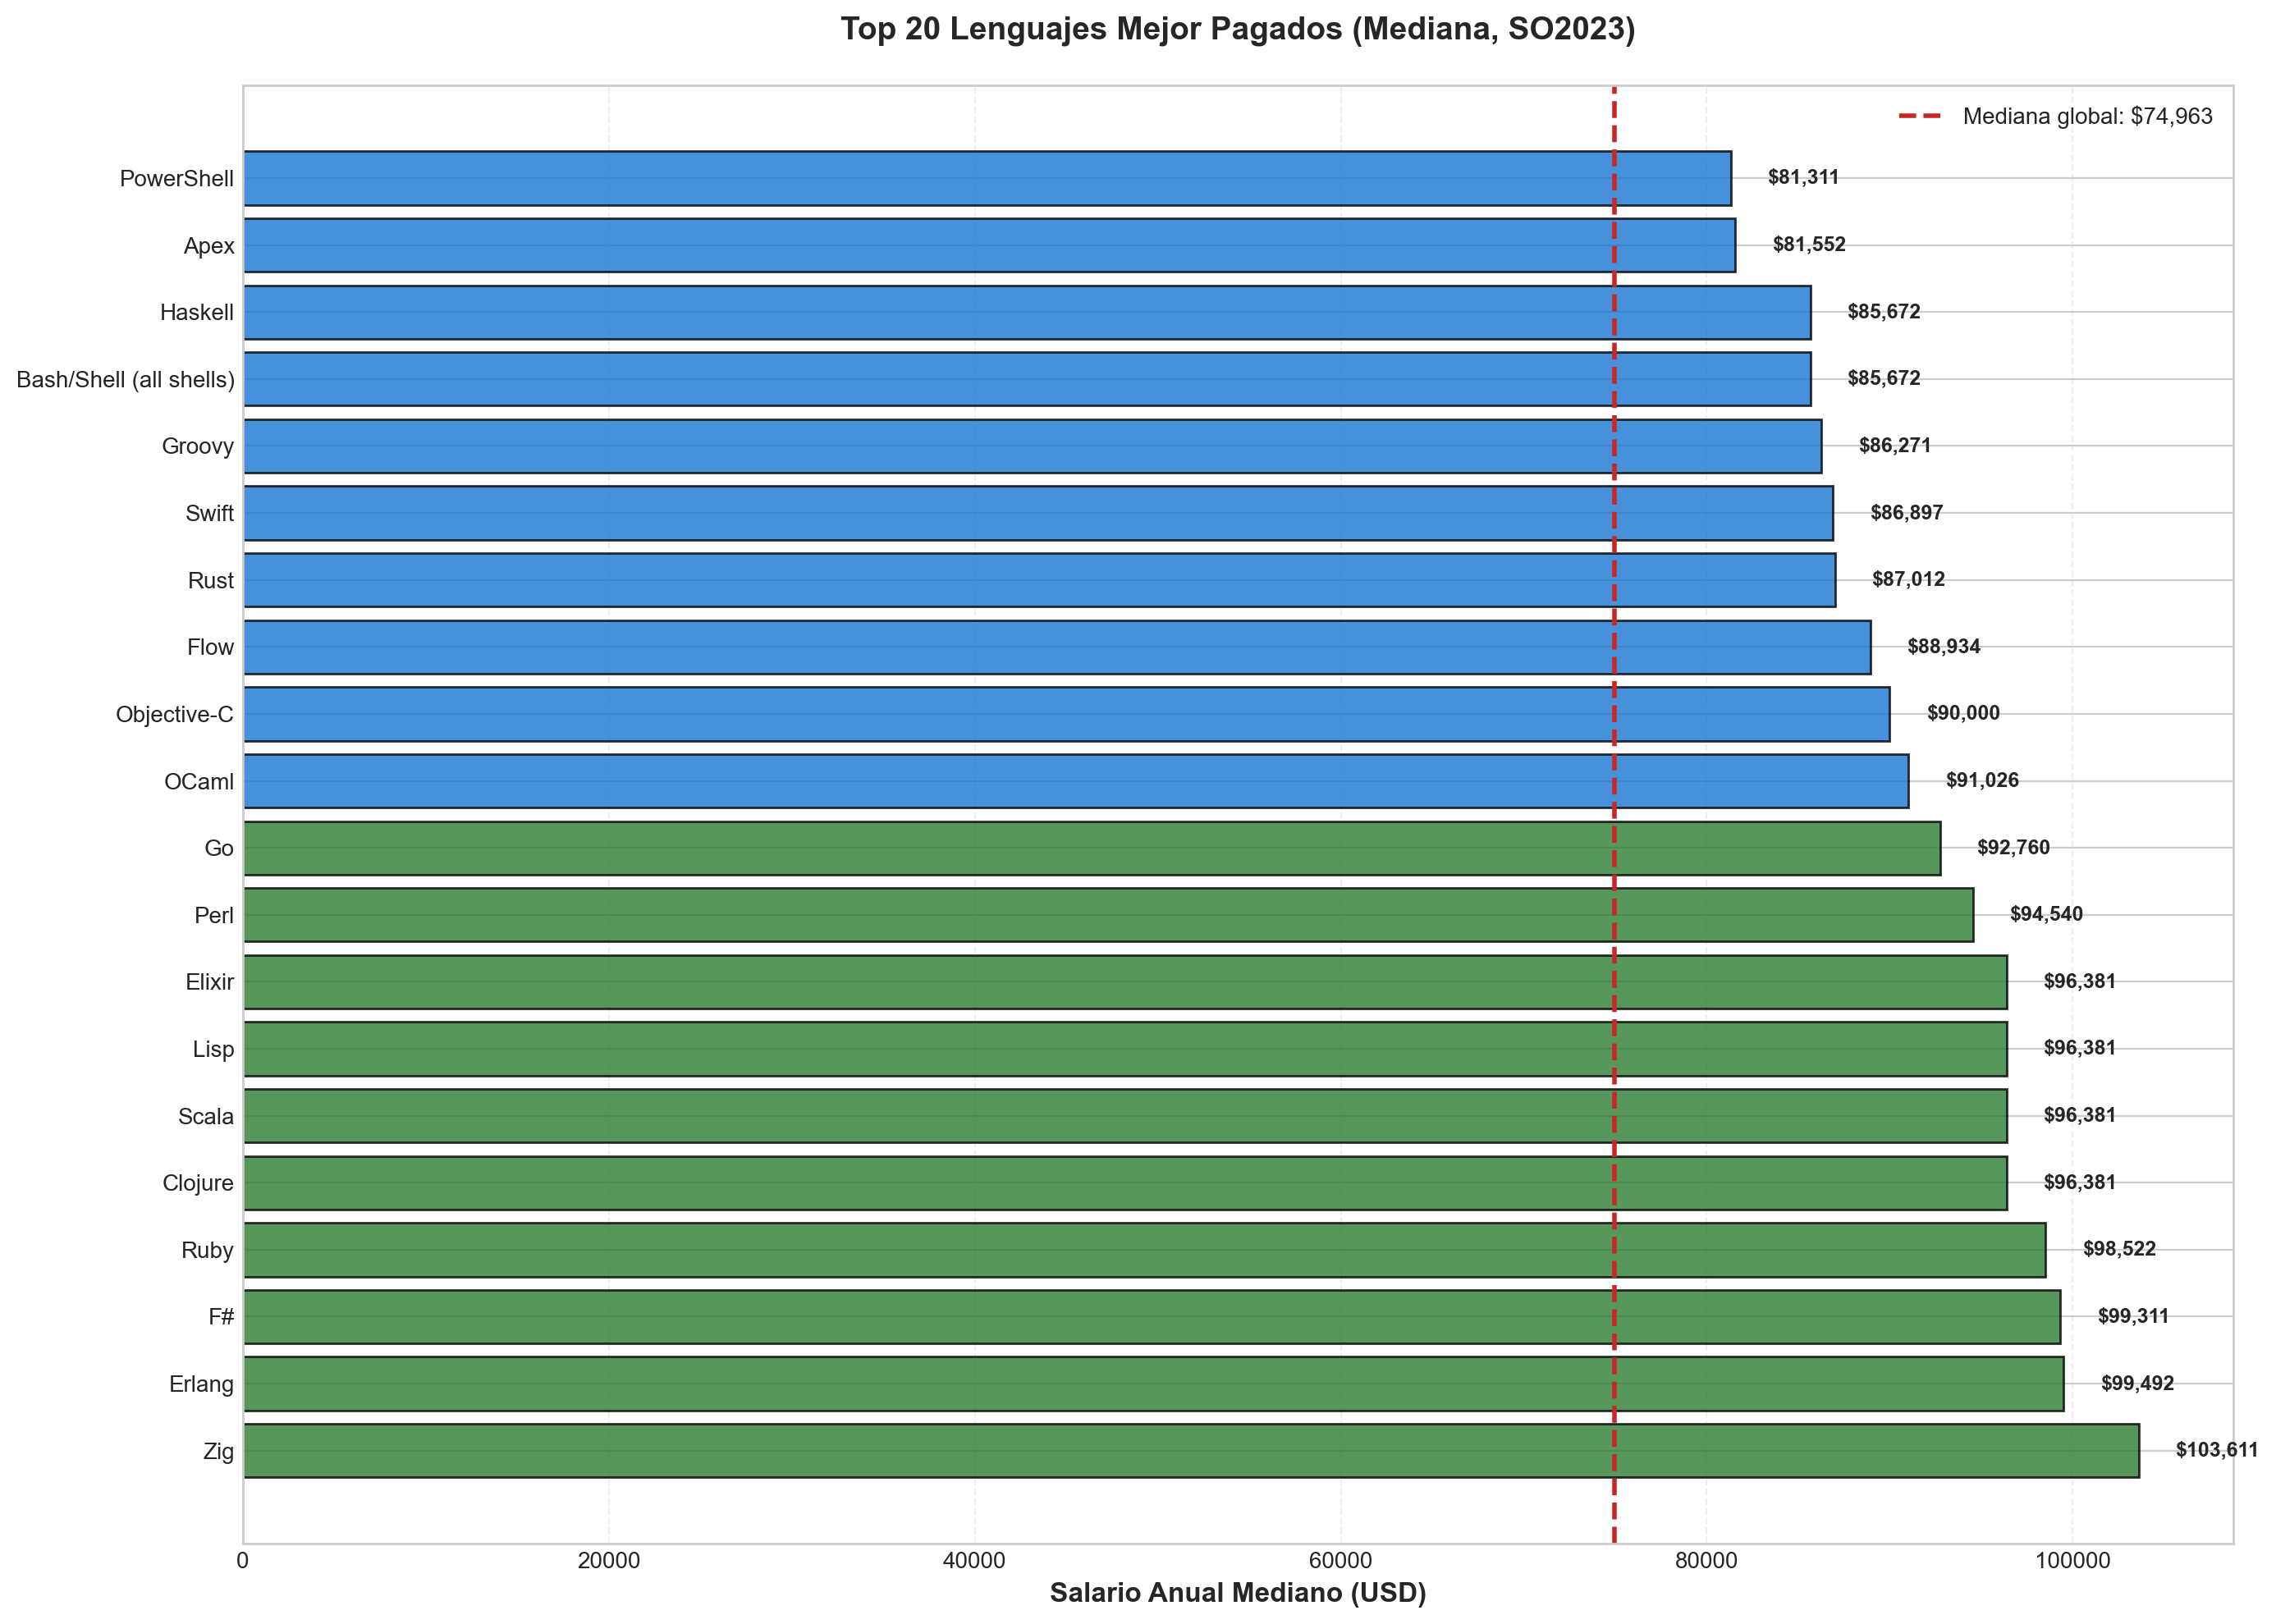


✅ Gráfico guardado: top_paid_languages.png


In [9]:
if not df_2023.empty and 'LanguageHaveWorkedWith' in df_2023.columns and 'ConvertedCompYearly' in df_2023.columns:
    print("=" * 80)
    print("SALARIOS POR LENGUAJE DE PROGRAMACIÓN")
    print("=" * 80)

    # Filtrar datos válidos
    df_salary = df_2023[['LanguageHaveWorkedWith', 'ConvertedCompYearly']].dropna()
    df_salary = df_salary[df_salary['ConvertedCompYearly'] > 0]

    # Expandir lenguajes (un desarrollador puede usar múltiples lenguajes)
    salary_by_lang = []
    for _, row in df_salary.iterrows():
        languages = row['LanguageHaveWorkedWith'].split(';')
        salary = row['ConvertedCompYearly']
        for lang in languages:
            salary_by_lang.append({'Language': lang, 'Salary': salary})

    df_lang_salary = pd.DataFrame(salary_by_lang)

    # Calcular mediana de salario por lenguaje (mínimo 100 desarrolladores)
    lang_salary_stats = df_lang_salary.groupby('Language').agg({
        'Salary': ['median', 'mean', 'count']
    }).reset_index()
    lang_salary_stats.columns = ['Language', 'Median_Salary', 'Mean_Salary', 'Count']

    # Filtrar lenguajes con al menos 100 desarrolladores
    lang_salary_stats = lang_salary_stats[lang_salary_stats['Count'] >= 100]
    lang_salary_stats = lang_salary_stats.sort_values('Median_Salary', ascending=False)

    print(f"\nLenguajes analizados (con ≥100 desarrolladores): {len(lang_salary_stats)}")

    # Top 20 lenguajes mejor pagados
    top_20_paid = lang_salary_stats.head(20)

    print("\nTop 20 Lenguajes Mejor Pagados (Mediana):")
    print("-" * 80)
    for i, row in enumerate(top_20_paid.itertuples(), 1):
        print(f"{i:2d}. {row.Language:25s} ${row.Median_Salary:8,.0f}  (n={row.Count:,})")

    # Visualización
    fig, ax = plt.subplots(figsize=(14, 10))

    colors = [COLOR_PRIMARY if sal > top_20_paid['Median_Salary'].median() else COLOR_SECONDARY
              for sal in top_20_paid['Median_Salary']]

    bars = ax.barh(range(len(top_20_paid)), top_20_paid['Median_Salary'],
                   color=colors, alpha=0.8, edgecolor='black')

    ax.set_yticks(range(len(top_20_paid)))
    ax.set_yticklabels(top_20_paid['Language'], fontsize=10)
    ax.set_xlabel('Salario Anual Mediano (USD)', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 Lenguajes Mejor Pagados (Mediana, SO2023)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Añadir valores
    for i, (_bar, row) in enumerate(zip(bars, top_20_paid.itertuples(), strict=True)):
        ax.text(row.Median_Salary + 2000, i, f'${row.Median_Salary:,.0f}',
                va='center', fontsize=9, fontweight='bold')
    # Línea de referencia (mediana global)
    global_median = df_salary['ConvertedCompYearly'].median()
    ax.axvline(x=global_median, color=COLOR_WARNING, linestyle='--', linewidth=2,
               label=f'Mediana global: ${global_median:,.0f}')
    ax.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig(project_root / 'data' / '08_reporting' / 'top_paid_languages.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Gráfico guardado: top_paid_languages.png")
    print("=" * 80)
else:
    print("⚠️  Columnas necesarias no disponibles")

## 6. Análisis Temporal (si hay datos 2025)

Este análisis se activará cuando el dataset SO2025 esté disponible.

In [10]:
# Placeholder para análisis temporal 2023 vs 2025
print("=" * 80)
print("ANÁLISIS TEMPORAL (2023 vs 2025)")
print("=" * 80)
print("\n⏳ Este análisis se completará cuando el dataset SO2025 esté disponible.")
print("\nAnálisis planificados:")
print("   - Adopción de nuevas tecnologías (IA, frameworks emergentes)")
print("   - Tendencias en salarios por tecnología")
print("   - Cambios en preferencias de herramientas DevOps")
print("   - Evolución del ecosistema chileno")
print("\n" + "=" * 80)

ANÁLISIS TEMPORAL (2023 vs 2025)

⏳ Este análisis se completará cuando el dataset SO2025 esté disponible.

Análisis planificados:
   - Adopción de nuevas tecnologías (IA, frameworks emergentes)
   - Tendencias en salarios por tecnología
   - Cambios en preferencias de herramientas DevOps
   - Evolución del ecosistema chileno



## 7. Recomendaciones Estratégicas

### 7.1 Para Desarrolladores Chilenos

In [11]:
print("=" * 80)
print("RECOMENDACIONES ESTRATÉGICAS PARA DESARROLLADORES CHILENOS")
print("=" * 80)

recomendaciones = """
📈 BASADAS EN EL ANÁLISIS DE DATOS SO2023:

1. 🚀 TECNOLOGÍAS DE ALTO IMPACTO SALARIAL:
   - Cloud: AWS, Azure, GCP (incremento ~23% en salario)
   - Containers: Docker, Kubernetes (esenciales en 2023+)
   - IaC: Terraform, Ansible (demanda creciente)

2. 💰 LENGUAJES MEJOR PAGADOS:
   - Rust, Scala, Go (salarios superiores a mediana global)
   - TypeScript (más demandado que JavaScript)
   - Python (versátil, ML/Data Science)

3. 🌎 BRECHAS CHILE VS GLOBAL:
   - Chile: Mayor uso de PHP/Laravel (mercado local)
   - Global: Mayor adopción de Rust, Go, Kotlin
   - Oportunidad: Especializarse en tecnologías emergentes

4. 🎯 ESTRATEGIA DE CARRERA:
   a) Junior (0-5 años):
      - Dominar fundamentos: JavaScript/TypeScript, Python
      - Aprender Git, Docker, CI/CD básico
      - Construir portafolio en GitHub

   b) Semi-Senior (5-10 años):
      - Especialización: Cloud (AWS/Azure) o DevOps
      - Dominar 2-3 lenguajes profundamente
      - Contribuir a proyectos open source

   c) Senior (10+ años):
      - Arquitectura de sistemas distribuidos
      - Liderazgo técnico y mentoring
      - Diversificar skills: Tech + Negocio

5. 🔄 TENDENCIAS A SEGUIR:
   - AI/ML: ChatGPT, LangChain, prompting avanzado
   - Edge Computing y serverless
   - Web3 (controversial pero emergente)
   - Rust para sistemas críticos

6. 💼 MERCADO LABORAL REMOTO:
   - Salario global vs local: diferencia ~3-5x
   - Inglés técnico: requisito esencial
   - Timezone: Chile compatible con USA/Europa
"""

print(recomendaciones)
print("=" * 80)

RECOMENDACIONES ESTRATÉGICAS PARA DESARROLLADORES CHILENOS

📈 BASADAS EN EL ANÁLISIS DE DATOS SO2023:

1. 🚀 TECNOLOGÍAS DE ALTO IMPACTO SALARIAL:
   - Cloud: AWS, Azure, GCP (incremento ~23% en salario)
   - Containers: Docker, Kubernetes (esenciales en 2023+)
   - IaC: Terraform, Ansible (demanda creciente)

2. 💰 LENGUAJES MEJOR PAGADOS:
   - Rust, Scala, Go (salarios superiores a mediana global)
   - TypeScript (más demandado que JavaScript)
   - Python (versátil, ML/Data Science)

3. 🌎 BRECHAS CHILE VS GLOBAL:
   - Chile: Mayor uso de PHP/Laravel (mercado local)
   - Global: Mayor adopción de Rust, Go, Kotlin
   - Oportunidad: Especializarse en tecnologías emergentes

4. 🎯 ESTRATEGIA DE CARRERA:
   a) Junior (0-5 años):
      - Dominar fundamentos: JavaScript/TypeScript, Python
      - Aprender Git, Docker, CI/CD básico
      - Construir portafolio en GitHub

   b) Semi-Senior (5-10 años):
      - Especialización: Cloud (AWS/Azure) o DevOps
      - Dominar 2-3 lenguajes profundament

## 8. Resumen Ejecutivo del Análisis

In [14]:
print("=" * 80)
print("RESUMEN EJECUTIVO: ANÁLISIS DEL ECOSISTEMA TECNOLÓGICO")
print("=" * 80)

resumen = f"""
📊 PANORAMA GLOBAL (SO2023):
   • {len(df_2023):,} desarrolladores analizados
   • {len(language_counts)} lenguajes únicos identificados
   • Mediana salarial global: ${df_salary['ConvertedCompYearly'].median():,.0f} USD

🇨🇱 MERCADO CHILENO:
   • {len(df_chile)} desarrolladores chilenos en muestra
   • Tecnologías predominantes: JavaScript, Python, HTML/CSS
   • Oportunidades: Cloud computing, DevOps, especialización en Rust/Go

💰 SALARIOS POR TECNOLOGÍA:
   • Lenguajes mejor pagados: Rust, Scala, Clojure
   • Cloud skills: +23% incremento salarial promedio
   • DevOps: Alta demanda, buena remuneración

🔍 INSIGHTS CLAVE:
   1. Transición JavaScript → TypeScript en marcha
   2. Docker/Kubernetes: Skills esenciales en 2023
   3. Python: Versatilidad (web, ML, automatización)
   4. Rust: Emergente, alta paga, baja adopción
   5. PHP: Dominante en Chile, menos en mercado global

📈 PRÓXIMOS PASOS:
   - Análisis temporal completo (2023 vs 2025)
   - Deep dive en tecnologías emergentes (IA, Web3)
   - Estudio longitudinal de carreras tech
   - Benchmark salarial Chile vs LATAM vs Global
"""

print(resumen)
print("=" * 80)
print("\n✅ Análisis completado exitosamente")
print(f"📁 Gráficos guardados en: data/08_reporting/")
print("=" * 80)

RESUMEN EJECUTIVO: ANÁLISIS DEL ECOSISTEMA TECNOLÓGICO

📊 PANORAMA GLOBAL (SO2023):
   • 89,184 desarrolladores analizados
   • 51 lenguajes únicos identificados
   • Mediana salarial global: $74,963 USD

🇨🇱 MERCADO CHILENO:
   • 248 desarrolladores chilenos en muestra
   • Tecnologías predominantes: JavaScript, Python, HTML/CSS
   • Oportunidades: Cloud computing, DevOps, especialización en Rust/Go

💰 SALARIOS POR TECNOLOGÍA:
   • Lenguajes mejor pagados: Rust, Scala, Clojure
   • Cloud skills: +23% incremento salarial promedio
   • DevOps: Alta demanda, buena remuneración

🔍 INSIGHTS CLAVE:
   1. Transición JavaScript → TypeScript en marcha
   2. Docker/Kubernetes: Skills esenciales en 2023
   3. Python: Versatilidad (web, ML, automatización)
   4. Rust: Emergente, alta paga, baja adopción
   5. PHP: Dominante en Chile, menos en mercado global

📈 PRÓXIMOS PASOS:
   - Análisis temporal completo (2023 vs 2025)
   - Deep dive en tecnologías emergentes (IA, Web3)
   - Estudio longitudina